In [3]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import numpy as np
import gensim
import string
import re
from nltk.tokenize import sent_tokenize
import plotly.express as px
from networkx.algorithms import community
from random import random
from tqdm import tqdm
from pyvis.network import Network

In [ ]:
#dataMBO.to_csv('dataMBO.csv')

## Load data

In [4]:
data = pd.read_csv('dutch-news-articles.csv')

In [5]:
dataMBO = data[data['content'].str.contains('MBO | MBO|Mbo| mbo| mbo|middelbaar beroeps onderwijs|middelbare beroeps opleiding|Middelbaar Beroeps Onderwijs|Middelbare Beroeps Opleiding|Middelbaar beroeps onderwijs|Middelbare beroeps opleiding')]
dataMBO

datetime   
777     2010-01-24 21:15:00  \
1046    2010-01-30 19:36:00   
1077    2010-01-31 22:43:00   
1081    2010-02-01 08:24:00   
1824    2010-02-19 18:26:00   
...                     ...   
250483  2023-03-24 17:40:10   
250845  2023-04-03 08:59:16   
251048  2023-04-07 21:10:02   
251162  2023-04-12 00:00:33   
251170  2023-04-12 09:37:39   

                                                    title   
777                   'Zorg probleemjeugd in het gedrang'  \
1046                   LTS nieuwe stijl doorslaand succes   
1077                             Eerherstel lts valt goed   
1081    Inspectie publiceert lijst met zwakke mbo-ople...   
1824    Albeda College: andere zaken belangrijker dan ...   
...                                                   ...   
250483  Caribische studenten krijgen al voor vertrek n...   
250845  Hoogste aantal voortijdige schoolverlaters in ...   
251048  Brancheorganisatie daagt Staat voor rechter om...   
251162  Deeltijdwerk al snel na diploma in trek onder ...   
251170  Taaltips LAKS: geen 'jongens en meisjes' en 'e...   

                                                  content    category   
777     Personeel in de jeugdzorg waarschuwt voor de t...  Binnenland  \
1046    Door verslaggever Pauline Broekema Een leger a...  Binnenland   
1077    Scholieren, ouders en docenten zijn blij met d...  Binnenland   
1081    De Inspectie van het Onderwijs heeft op intern...  Binnenland   
1824    Door redacteur Jikke Zijlstra Priscilla (24) h...  Binnenland   
...                                                   ...         ...   
250483  Nog voordat aspirant-studenten uit het Caribis...  Binnenland   
250845  Steeds meer jongeren gaan zonder diploma van s...    Politiek   
251048  Het kabinet moet het aanstaande verbod op e-si...  Binnenland   
251162  Minder dan 35 uur per week werken is vaker de ...    Economie   
251170  Scholierenorganisatie LAKS vindt het de hoogst...  Binnenland   

                                                      url  
777     https://nos.nl/artikel/131574-zorg-probleemjeu...  
1046    https://nos.nl/artikel/133118-lts-nieuwe-stijl...  
1077    https://nos.nl/artikel/133227-eerherstel-lts-v...  
1081    https://nos.nl/artikel/133363-inspectie-public...  
1824    https://nos.nl/artikel/138116-albeda-college-a...  
...                                                   ...  
250483  https://nos.nl//artikel/2468719-caribische-stu...  
250845  https://nos.nl//artikel/2469965-hoogste-aantal...  
251048  https://nos.nl//artikel/2470570-brancheorganis...  
251162  https://nos.nl//artikel/2471090-deeltijdwerk-a...  
251170  https://nos.nl//artikel/2471107-taaltips-laks-...  

[790 rows x 5 columns]

In [6]:
pd.to_datetime(dataMBO['datetime']).dt.year.value_counts()

datetime
2018    104
2020     99
2021     87
2016     68
2022     59
2017     56
2013     53
2015     53
2014     52
2019     52
2012     41
2011     26
2010     22
2023     18
Name: count, dtype: int64

In [7]:
# Count category frequency table
category_counts = dataMBO['category'].value_counts()

# Print the frequency table
print(category_counts)


category
Binnenland          486
Politiek            167
Economie             69
Regionaal nieuws     47
Buitenland           14
Koningshuis           4
Tech                  1
Regio                 1
Omroep Brabant        1
Name: count, dtype: int64


## Preprocessing

In [4]:
def preprocess(text_col):
    # convert to lowercase
    text_col = text_col.apply(lambda x: ' '.join([w.lower() for w in x.split()]))
    
    # remove punctuation
    text_col = text_col.apply(lambda x: ''.join([i for i in x if i not in string.punctuation]))
    
    # remove numbers
    text_col = text_col.apply(lambda x: ' '.join(re.sub("[^a-zA-Z]+", " ", x).split()))

    # remove stopwords
    lst = 'de en van ik te dat die in een hij het niet zijn is was op aan met als voor had er maar om hem dan zou of wat mijn men dit zo door over ze zich bij ook tot je mij uit der daar haar naar heb hoe heeft hebben deze u want nog zal me zij nu ge geen omdat iets worden toch al waren veel meer doen toen moet ben zonder kan hun dus alles onder ja eens hier  wie werd  altijd doch  wordt wezen kunnen ons zelf tegen na reeds wil kon niets uw iemand geweest andere aan af al alle alleen alles als alsmede ander andere anders ben bij bijna bijv bijvoorbeeld binnen boven bovendien bv daar daaraan daarbij daarbuiten daardoor daarin daarna daarnaast daarom daaronder daarop daarover daartoe daaruit daarvan daarvoor dan dat de der deze die dit door doordat dus dwz echter een eens eerst en enz er ermee erg ergens ervan ervaring ervoor etc even evenals eveneens ge geen gehad geweest geworden had hadden heb hebben hebt heden heeft hem hen het hier hieraan hierbij hierdoor hierin hiermee hierna hieronder hierop hiertoe hieruit hiervan hiervoor hij hoe hoewel hun ik in indien is ja je jij jullie kan kon konden kunt kunnen maar maw me mee men met middels mijn misschien mits na naar naast nadat nee net niet niets nl nog nogal nou nu of om omdat ondermeer ons onze ook op over overig overige overigens reeds sinds slechts soms tbv te tegen ten tenzij ter terug terwijl tevens tijdens toch toe toen tot totdat tussen uit uw vaak van vanaf vandaar vanuit vanwege vervolgens volgens voor vooraf vooral voordat voorheen voornamelijk waar waaraan waarbij waardoor waarin waarmee waarna waarom waarop waaronder waaruit waarvan waarvoor wanneer want waren was wat we weer wel welk welke wellicht werd werden wie wij worden wordt zal ze zeer zelf zelfs zich zij zijn zo zoals zodat zonder zowel zou zouden zult zullen'

    def convert(lst):
        return ([i for i in lst.split()])

    list = convert(lst)
    
    additional_stopwords = ['mensen', 'jongeren', 'minister', 'komen', 'komt', 'twee', 'drie', 'vier', 'vijf', 'zes', 'zeven', 'acht', 'negen', 'tien', 'krijgen', 'maken', 'wel', 'gaat', 'gaan', 'zegt', 'volgens', 'studenten', 'leerlingen', 'volgens', 'jaar', 'scholen', 'school', 'moeten', 'mbo', 'onderwijs']
    stopwords = set(nltk.corpus.stopwords.words('dutch') + additional_stopwords + list)
    
    text_col = text_col.apply(lambda x: ' '.join([w for w in x.split() if w not in stopwords]))

    # remove short words
    text_col = text_col.apply(lambda x: ' '.join([w.strip() for w in x.split() if len(w.strip()) >= 4]))

    # tokenize
    text_col = text_col.apply(nltk.word_tokenize)
    
    return text_col

dataMBO['processed_text'] = preprocess(dataMBO['content'])
dataMBO

C:\Users\User\AppData\Local\Temp\ipykernel_8328\1656788739.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataMBO['processed_text'] = preprocess(dataMBO['content'])


datetime   
777     2010-01-24 21:15:00  \
1046    2010-01-30 19:36:00   
1077    2010-01-31 22:43:00   
1081    2010-02-01 08:24:00   
1824    2010-02-19 18:26:00   
...                     ...   
250483  2023-03-24 17:40:10   
250845  2023-04-03 08:59:16   
251048  2023-04-07 21:10:02   
251162  2023-04-12 00:00:33   
251170  2023-04-12 09:37:39   

                                                    title   
777                   'Zorg probleemjeugd in het gedrang'  \
1046                   LTS nieuwe stijl doorslaand succes   
1077                             Eerherstel lts valt goed   
1081    Inspectie publiceert lijst met zwakke mbo-ople...   
1824    Albeda College: andere zaken belangrijker dan ...   
...                                                   ...   
250483  Caribische studenten krijgen al voor vertrek n...   
250845  Hoogste aantal voortijdige schoolverlaters in ...   
251048  Brancheorganisatie daagt Staat voor rechter om...   
251162  Deeltijdwerk al snel na diploma in trek onder ...   
251170  Taaltips LAKS: geen 'jongens en meisjes' en 'e...   

                                                  content    category   
777     Personeel in de jeugdzorg waarschuwt voor de t...  Binnenland  \
1046    Door verslaggever Pauline Broekema Een leger a...  Binnenland   
1077    Scholieren, ouders en docenten zijn blij met d...  Binnenland   
1081    De Inspectie van het Onderwijs heeft op intern...  Binnenland   
1824    Door redacteur Jikke Zijlstra Priscilla (24) h...  Binnenland   
...                                                   ...         ...   
250483  Nog voordat aspirant-studenten uit het Caribis...  Binnenland   
250845  Steeds meer jongeren gaan zonder diploma van s...    Politiek   
251048  Het kabinet moet het aanstaande verbod op e-si...  Binnenland   
251162  Minder dan 35 uur per week werken is vaker de ...    Economie   
251170  Scholierenorganisatie LAKS vindt het de hoogst...  Binnenland   

                                                      url   
777     https://nos.nl/artikel/131574-zorg-probleemjeu...  \
1046    https://nos.nl/artikel/133118-lts-nieuwe-stijl...   
1077    https://nos.nl/artikel/133227-eerherstel-lts-v...   
1081    https://nos.nl/artikel/133363-inspectie-public...   
1824    https://nos.nl/artikel/138116-albeda-college-a...   
...                                                   ...   
250483  https://nos.nl//artikel/2468719-caribische-stu...   
250845  https://nos.nl//artikel/2469965-hoogste-aantal...   
251048  https://nos.nl//artikel/2470570-brancheorganis...   
251162  https://nos.nl//artikel/2471090-deeltijdwerk-a...   
251170  https://nos.nl//artikel/2471107-taaltips-laks-...   

                                           processed_text  
777     [personeel, jeugdzorg, waarschuwt, toestand, i...  
1046    [verslaggever, pauline, broekema, leger, vakme...  
1077    [scholieren, ouders, docenten, blij, nieuwe, s...  
1081    [inspectie, internet, lijst, gepubliceerd, zwa...  
1824    [redacteur, jikke, zijlstra, priscilla, baby, ...  
...                                                   ...  
250483  [aspirantstudenten, caribisch, deel, koninkrij...  
250845  [steeds, diploma, studiejaar, stopten, ruim, a...  
251048  [kabinet, aanstaande, verbod, esigaretten, sma...  
251162  [minder, week, werken, vaker, norm, vrouwen, m...  
251170  [scholierenorganisatie, laks, vindt, hoogste, ...  

[790 rows x 6 columns]

## Exploratory analysis

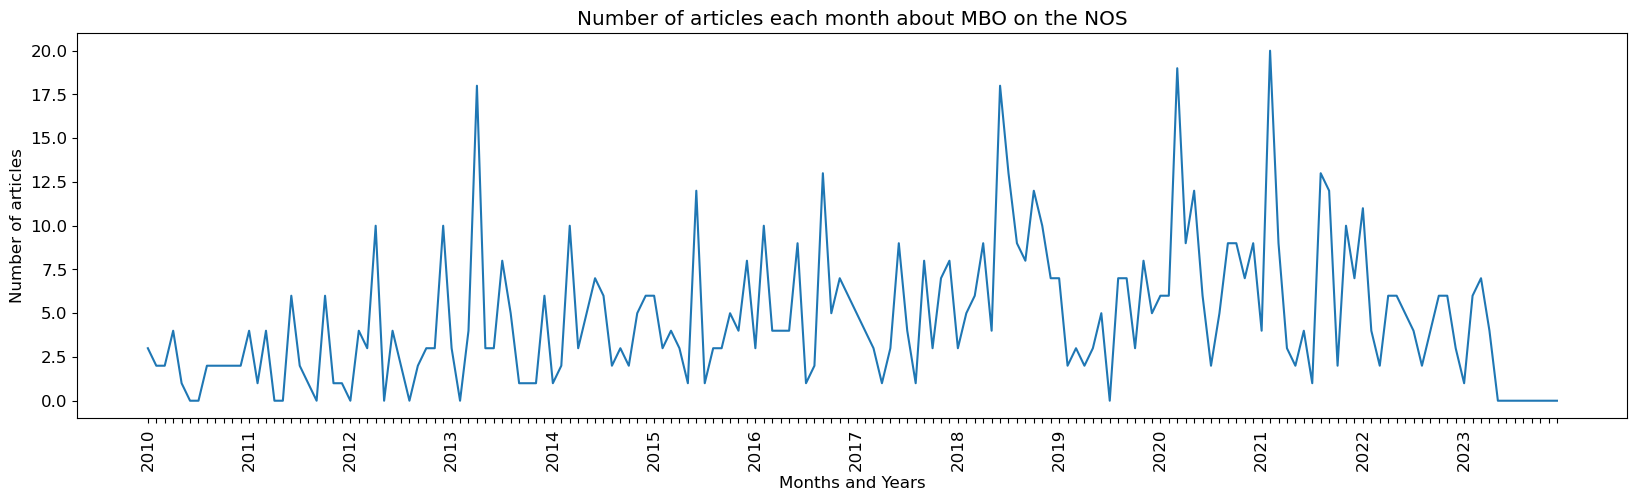

In [141]:
# Graph of month/year count of articles
dataMBO['datetime'] = pd.to_datetime(dataMBO['datetime'])
df = dataMBO['datetime'].groupby([dataMBO['datetime'].dt.year, dataMBO['datetime'].dt.month]).count().unstack(fill_value=0).stack()

font = {'size'   : 12}

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(5)

df.plot()
xticks = [(str(year)) if month == 1 else ('') for year, month in df.index.tolist()]
plt.xticks(np.arange(df.shape[0]), xticks, rotation=90);
plt.gca().set_xlabel('')
plt.rc('font', **font)

plt.title("Number of articles each month about MBO on the NOS")
plt.xlabel("Months and Years")
plt.ylabel("Number of articles")

plt.show()

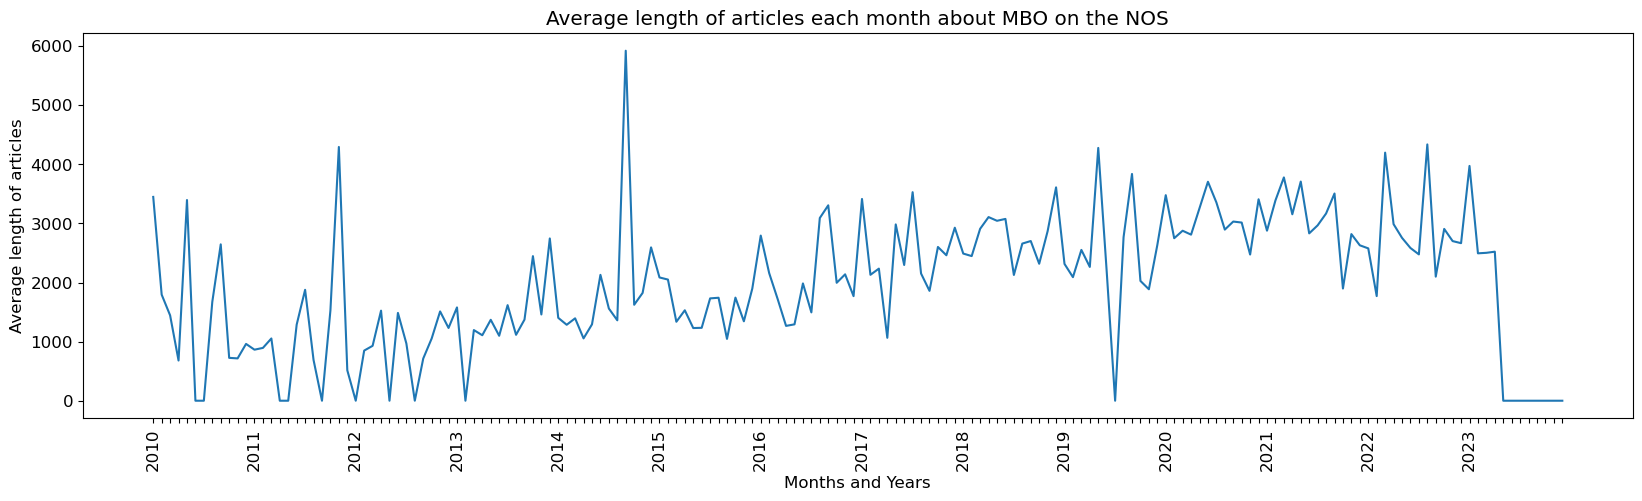

In [142]:
# Graph of average length of articles
dataMBO['content'] = dataMBO['content'].astype('str')

df2 = dataMBO.content.str.len().groupby([dataMBO['datetime'].dt.year, dataMBO['datetime'].dt.month]).mean().unstack(fill_value=0).stack()

font = {'size'   : 12}

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(5)

df2.plot()
xticks = [(str(year)) if month == 1 else ('') for year, month in df2.index.tolist()]
plt.xticks(np.arange(df2.shape[0]), xticks, rotation=90);
plt.gca().set_xlabel('')
plt.rc('font', **font)

plt.title("Average length of articles each month about MBO on the NOS")
plt.xlabel("Months and Years")
plt.ylabel("Average length of articles")

plt.show()

In [143]:
# Average length of articles before pre-processing
print(dataMBO.content.str.len().mean())

# Average length of articles after pre-processing
print(dataMBO.processed_text.str.len().mean())

# Average length of articles for each year before pre-processing
df2 = dataMBO.content.str.len().groupby([dataMBO['datetime'].dt.year]).mean()
print(df2)

# Average number of articles for each year
df = dataMBO['datetime'].groupby([dataMBO['datetime'].dt.year]).count()
print(df)


2390.9556962025317
153.30253164556962
datetime
2010    1654.363636
2011    1335.346154
2012    1237.707317
2013    1455.811321
2014    1928.173077
2015    1585.679245
2016    2223.926471
2017    2546.767857
2018    2766.711538
2019    2633.788462
2020    3053.929293
2021    3197.770115
2022    2709.949153
2023    2586.500000
Name: content, dtype: float64
datetime
2010     22
2011     26
2012     41
2013     53
2014     52
2015     53
2016     68
2017     56
2018    104
2019     52
2020     99
2021     87
2022     59
2023     18
Name: datetime, dtype: int64


C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\Users\Use

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\Users\U

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\Users\U

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\Users\U

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\Users\U

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\Users\Use

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\Users\Use

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

C:\Users\User\

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\Users\Use

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:499: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

C:\Users\User\

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:499: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\Users\User\

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\Users\U

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.



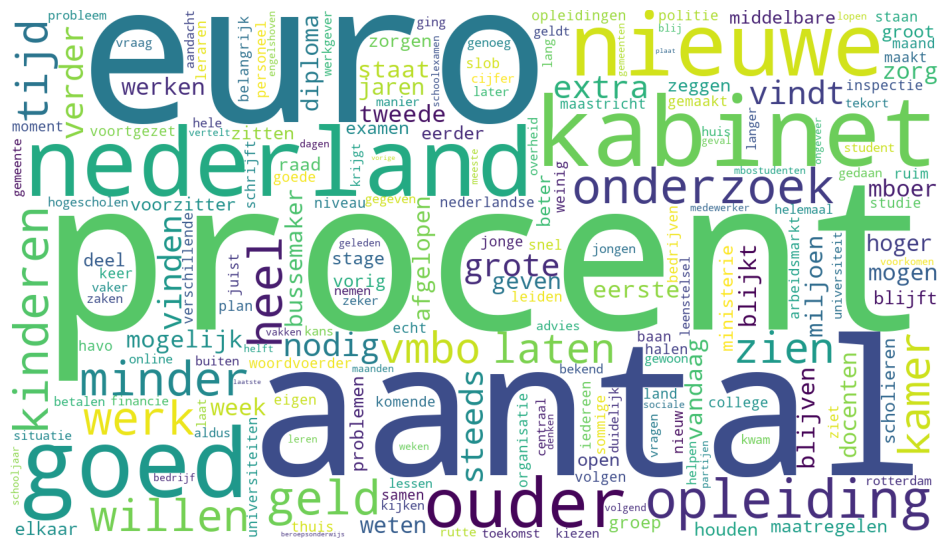

In [144]:
#Wordcloud
from wordcloud import WordCloud, STOPWORDS

bigstring = dataMBO['processed_text'].apply(lambda x: ' '.join(x)).str.cat(sep=' ')
plt.figure(figsize=(12,12))
wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white',
                          collocations=False,
                          width=1400,
                          height=800
                         ).generate(bigstring)
plt.axis('off')
plt.imshow(wordcloud)

In [145]:
#Top 10 word occurences
import re
words = dataMBO['processed_text'].dropna()\
                            .apply(lambda y: pd.value_counts(re.findall('([\s]\w+[\s])',' '.join(y))))\
                            .sum(axis=0)\
                            .to_frame()\
                            .reset_index()\
                            .sort_values(by=0,ascending=False)
words.columns = ['word','occurences']
words.head(20)

<>:4: DeprecationWarning:

invalid escape sequence \s

<>:4: DeprecationWarning:

invalid escape sequence \s

C:\Users\User\AppData\Local\Temp\ipykernel_16588\3800045667.py:4: DeprecationWarning:

invalid escape sequence \s



word  occurences
437     procent        279.0
290        euro        231.0
675     kabinet        215.0
451      aantal        212.0
4          goed        209.0
36    opleiding        187.0
525   onderzoek        187.0
419   nederland        173.0
834        geld        170.0
559      minder        166.0
116      nieuwe        165.0
179      ouders        163.0
118      willen        155.0
120        werk        152.0
204        zien        151.0
160    kinderen        151.0
197        tijd        150.0
536      verder        147.0
16       vinden        144.0
597        heel        140.0

## LDA

In [12]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(dataMBO['processed_text'])

# Create Corpus
texts = dataMBO['processed_text']

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 1), (23, 4), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]


### Baselinemodel

In [13]:
from pprint import pprint
# number of topics
num_topics = 10

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.011*"euro" + 0.007*"kabinet" + 0.006*"geld" + 0.006*"procent" + '
  '0.005*"nieuwe" + 0.005*"miljoen" + 0.005*"kamer" + 0.004*"extra" + '
  '0.004*"leenstelsel" + 0.004*"kinderen"'),
 (1,
  '0.007*"politie" + 0.004*"waterstof" + 0.004*"nodig" + 0.003*"jongen" + '
  '0.003*"nieuwe" + 0.003*"kinderen" + 0.003*"huis" + 0.003*"leiden" + '
  '0.003*"groningen" + 0.002*"woordvoerder"'),
 (2,
  '0.004*"tweede" + 0.003*"kamer" + 0.003*"werk" + 0.003*"bedrijven" + '
  '0.003*"zien" + 0.003*"betalen" + 0.003*"rotterdam" + 0.003*"bussen" + '
  '0.003*"partijen" + 0.003*"onderzoek"'),
 (3,
  '0.005*"nederland" + 0.004*"boas" + 0.003*"nederlandse" + 0.003*"personeel" '
  '+ 0.003*"nodig" + 0.002*"aantal" + 0.002*"economie" + 0.002*"moment" + '
  '0.002*"voorzitter" + 0.002*"arbeidsmarkt"'),
 (4,
  '0.008*"opleiding" + 0.005*"mboers" + 0.004*"nederland" + 0.004*"goed" + '
  '0.004*"vinden" + 0.004*"onderzoek" + 0.003*"arbeidsmarkt" + 0.003*"werk" + '
  '0.003*"stage" + 0.003*"steeds"'),
 (

In [51]:
from gensim.models import CoherenceModel

# Compute Perplexity (lower is better)
print('Perplexity: ', round(lda_model.log_perplexity(corpus), 2))

# Compute Coherence Score (higher is better)
coherence_model_lda = CoherenceModel(model=lda_model, texts=dataMBO['processed_text'], dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Perplexity:  -8.78
Coherence Score:  0.36810730900960864


### Grid search

In [52]:
# Test best # of topics
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=dataMBO['processed_text'], dictionary=id2word, coherence='c_v')
    perplexity_model_lda = lda_model.log_perplexity(corpus)
    return coherence_model_lda.get_coherence(), perplexity_model_lda

In [53]:
# Test best # of topics
import numpy as np
import tqdm

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]

corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence & Perplexity': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence & Perplexity'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('./results/lda_tuning_results.csv', index=False)
    pbar.close()

100%|██████████████████████████████████████████████████████████████████████████████| 540/540 [2:58:00<00:00, 19.78s/it]


### Final model

In [42]:
# Final model
num_topics = 10

final_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.909999999999999,
                                           eta=0.9099999999999999)

# Print the Keyword in the 9 topics
pprint(final_model.print_topics())
doc_lda = final_model[corpus]

[(0,
  '0.000*"pleegvader" + 0.000*"euroskills" + 0.000*"jeugdzorg" + '
  '0.000*"mustafa" + 0.000*"scheffers" + 0.000*"openingsceremonie" + '
  '0.000*"claim" + 0.000*"jury" + 0.000*"hoofdgerecht" + 0.000*"cases"'),
 (1,
  '0.005*"kabinet" + 0.004*"aantal" + 0.004*"procent" + 0.004*"goed" + '
  '0.003*"kinderen" + 0.003*"nieuwe" + 0.003*"opleiding" + 0.003*"heel" + '
  '0.003*"blijven" + 0.003*"nederland"'),
 (2,
  '0.001*"bayat" + 0.001*"belgische" + 0.000*"veljkovic" + 0.000*"verhoor" + '
  '0.000*"transfers" + 0.000*"clubs" + 0.000*"club" + 0.000*"politie" + '
  '0.000*"verricht" + 0.000*"charleroi"'),
 (3,
  '0.001*"rechter" + 0.000*"piloot" + 0.000*"tekst" + 0.000*"zwijgrecht" + '
  '0.000*"benaouf" + 0.000*"rechtbank" + 0.000*"verdachten" + '
  '0.000*"gevangenis" + 0.000*"muur" + 0.000*"colombiaanse"'),
 (4,
  '0.003*"procent" + 0.003*"nederland" + 0.003*"vacatures" + 0.003*"tekort" + '
  '0.003*"aantal" + 0.003*"zorg" + 0.002*"personeel" + 0.002*"arbeidsmarkt" + '
  '0.002*"pa

### Visualisation

In [75]:
import pyLDAvis.gensim

# Assuming you have already defined final_model, corpus, and id2word
vis_data = pyLDAvis.gensim.prepare(final_model, corpus, id2word,sort_topics=False)
pyLDAvis.display(vis_data)



In [77]:
#Save visualisation
pyLDAvis.save_html(vis_data, 'lda.html')

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:499: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:520: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  Image.ROTATE_90)
C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordclo

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_fo

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_fo

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_fo

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transpose

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_fo

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_fo

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:499: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:520: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  Image.ROTATE_90)
C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordclo

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:499: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:520: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  Image.ROTATE_90)
C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordclo

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_fo

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_fo

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_fo

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:499: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
C:\Users\User\anacond

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_fo

C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
C:\Users\User\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transpose

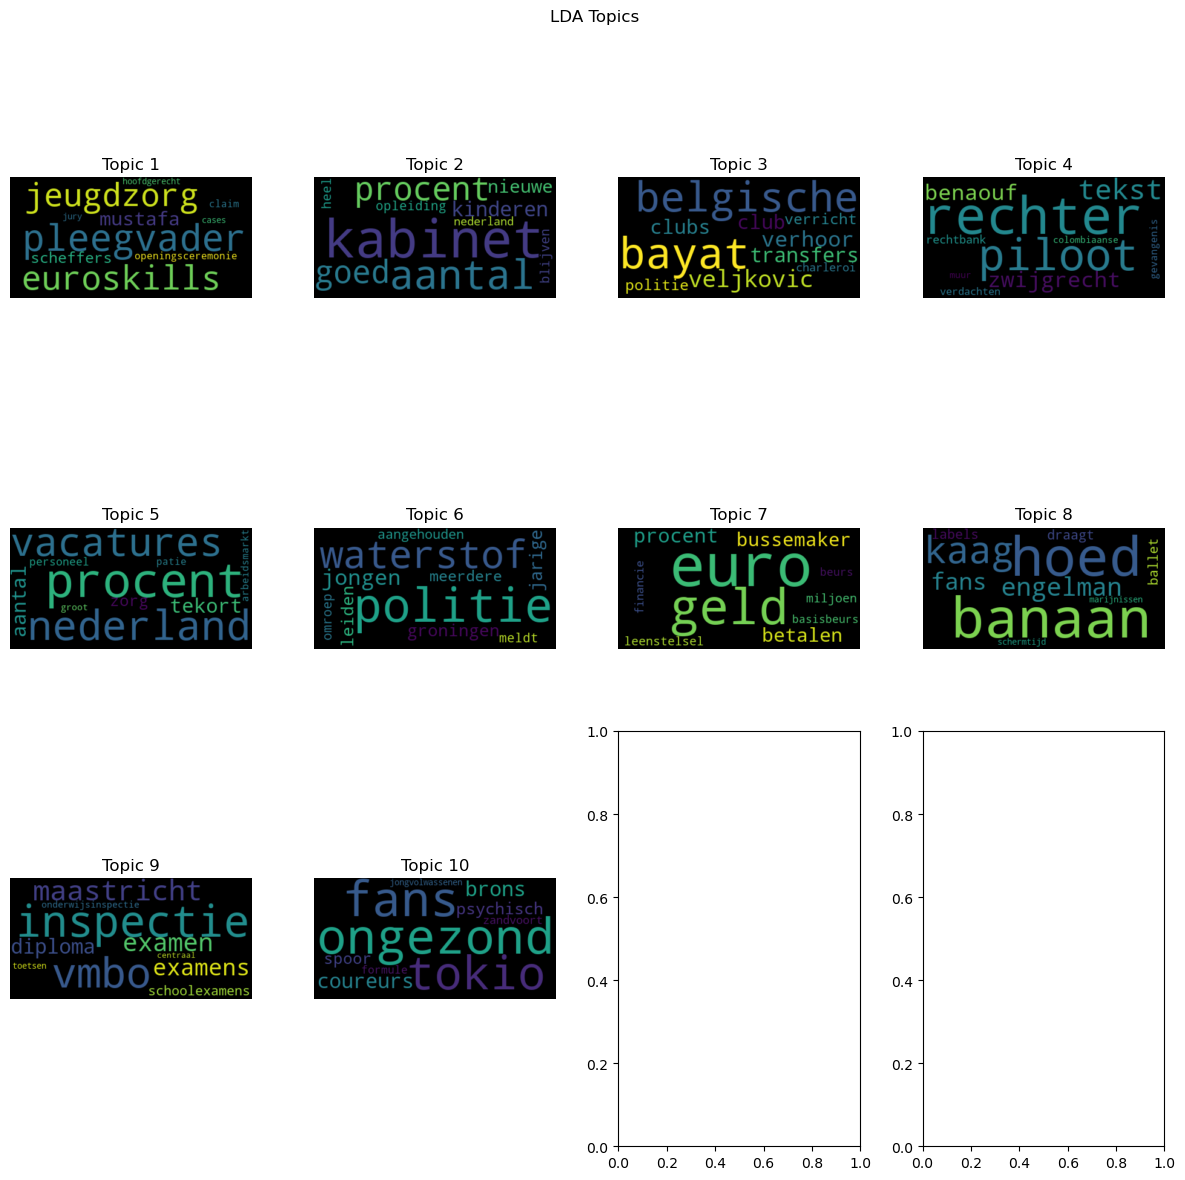

In [76]:
#Create word cloud for each topic

import matplotlib.pyplot as plt
from wordcloud import WordCloud
from operator import itemgetter

num_topics = final_model.num_topics
num_rows = num_topics // 4 + (num_topics % 4 > 0)
num_cols = min(4, num_topics)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4*num_rows))
fig.suptitle("LDA Topics")
axes = axes.flatten()  # Flatten the 2D axes array into a 1D array

for i in range(num_topics):
    ax = axes[i]
    topic_words = final_model.show_topic(i)
    word_freq = {word: freq for word, freq in topic_words}
    wordcloud = WordCloud()
    wordcloud.generate_from_frequencies(word_freq)
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.set_title("Topic " + str(i+1))
    ax.axis("off")

plt.tight_layout()  # Adjust the spacing between subplots if needed
plt.show()


In [52]:
topics = final_model.get_document_topics(corpus, per_word_topics=True)
all_topics = [(doc_topics, word_topics, word_phis) for doc_topics, word_topics, word_phis in topics]

for doc in all_topics:
    print('New Document \n')
    print('Document topic:', doc[0])
    print('Word topic:', doc[1])
    print('Phi value:', doc[2])
    print(" ")
    print('-------------- \n')


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[(12, [(1, 0.9841612)]), (43, [(1, 5.9671516), (6, 0.023590146)]), (74, [(1, 0.9702649)]), (85, [(1, 0.9729505), (6, 0.01446115)]), (93, [(1, 0.9922788)]), (99, [(1, 0.9757747), (6, 0.019317105)]), (123, [(1, 0.9739723), (6, 0.012772412)]), (139, [(1, 0.9761772), (6, 0.018223759)]), (180, [(1, 3.9505622), (4, 0.012956365), (6, 0.023530621)]), (182, [(1, 0.99167013)]), (195, [(1, 0.9882158)]), (207, [(1, 0.98635656)]), (225, [(1, 1.9542367), (6, 0.027822642)]), (230, [(1, 0.9856672)]), (234, [(1, 1.9680899), (6, 0.018878538)]), (256, [(1, 0.9856535)]), (302, [(1, 1.9784076), (6, 0.010125365)]), (335, [(1, 0.99614364)]), (338, [(1, 0.97410494), (6, 0.016470702)]), (364, [(1, 0.9898403)]), (367, [(1, 0.97899973), (6, 0.011593949)]), (390, [(1, 0.9849414)]), (401, [(1, 0.9892265)]), (463, [(1, 0.9871382)]), (494, [(1, 1.9662433), (6, 0.020374425)]), (530, [(1, 0.9570721), (6, 0.02773142)]), (568, [(1, 1.9796835)]), (593, [(1, 0.97882104), (6, 0.014806922)]), (601, [(1, 0.9902403)]), (602, 

In [80]:
# Create top 5 article titles for each topic

import pandas as pd
# Create a new DataFrame to store the document topic probabilities and titles
topic_data = pd.DataFrame(columns=['Publication Date', 'Title'] + ['Topic {}'.format(i) for i in range(num_topics)])

# Iterate over each document and extract the topic probabilities, publication date, and title
for i, doc in enumerate(all_topics):
    doc_topics = doc[0]
    publication_date = dataMBO['datetime'].iloc[i]
    title = dataMBO['title'].iloc[i]
    
    # Create a dictionary to store the topic probabilities, publication date, and title
    topic_prob_dict = {'Publication Date': publication_date, 'Title': title}
    for topic, prob in doc_topics:
        topic_prob_dict['Topic {}'.format(topic)] = prob
    
    # Append the topic probabilities, publication date, and title to the DataFrame
    topic_data = pd.concat([topic_data, pd.DataFrame([topic_prob_dict])], ignore_index=True)

# Convert the publication date column to datetime format
topic_data['Publication Date'] = pd.to_datetime(topic_data['Publication Date'])

# Get the top 5 documents for each topic
top_5_documents = pd.DataFrame()
for i in range(num_topics):
    topic_name = 'Topic {}'.format(i)
    top_documents = topic_data.nlargest(5, topic_name)
    top_documents['Topic'] = topic_name
    top_5_documents = pd.concat([top_5_documents, top_documents])

top_documents_with_titles = top_5_documents[['Topic', 'Publication Date', 'Title']]

pd.set_option('display.max_colwidth', None)

top_documents_with_titles

Topic    Publication Date   
443  Topic 0 2018-09-26 12:40:00  \
308  Topic 0 2016-11-28 17:26:00   
350  Topic 0 2017-09-19 16:12:00   
5    Topic 0 2010-03-26 12:47:00   
47   Topic 0 2011-12-08 16:02:00   
581  Topic 1 2020-06-06 09:53:00   
549  Topic 1 2020-03-13 14:28:00   
684  Topic 1 2021-09-11 07:06:00   
644  Topic 1 2021-02-23 20:10:00   
653  Topic 1 2021-03-03 04:00:00   
449  Topic 2 2018-10-10 11:16:00   
47   Topic 2 2011-12-08 16:02:00   
5    Topic 2 2010-03-26 12:47:00   
106  Topic 2 2013-04-23 16:18:00   
350  Topic 2 2017-09-19 16:12:00   
345  Topic 3 2017-09-01 18:20:00   
440  Topic 3 2018-09-11 14:31:00   
47   Topic 3 2011-12-08 16:02:00   
5    Topic 3 2010-03-26 12:47:00   
106  Topic 3 2013-04-23 16:18:00   
660  Topic 4 2021-04-26 01:19:00   
708  Topic 4 2021-12-02 17:16:00   
669  Topic 4 2021-08-03 19:17:00   
707  Topic 4 2021-12-02 17:16:00   
600  Topic 4 2020-09-28 06:38:00   
754  Topic 5 2022-09-08 23:45:35   
616  Topic 5 2020-11-30 18:01:00   
342  Topic 5 2017-07-16 01:15:00   
625  Topic 5 2020-12-28 07:11:00   
741  Topic 5 2022-05-31 18:26:00   
688  Topic 6 2021-09-19 15:56:00   
758  Topic 6 2022-10-11 16:50:09   
393  Topic 6 2018-04-27 07:00:00   
784  Topic 6 2023-03-24 11:02:33   
729  Topic 6 2022-03-30 09:08:00   
487  Topic 7 2019-04-12 22:44:00   
290  Topic 7 2016-09-20 10:05:00   
524  Topic 7 2019-12-09 15:48:00   
650  Topic 7 2021-03-01 07:00:00   
350  Topic 7 2017-09-19 16:12:00   
463  Topic 8 2018-11-14 17:37:00   
636  Topic 8 2021-02-10 22:12:00   
422  Topic 8 2018-07-10 10:52:00   
403  Topic 8 2018-06-22 16:40:00   
414  Topic 8 2018-06-29 03:51:00   
683  Topic 9 2021-09-03 06:58:00   
121  Topic 9 2013-07-02 22:13:00   
47   Topic 9 2011-12-08 16:02:00   
5    Topic 9 2010-03-26 12:47:00   
53   Topic 9 2012-03-14 15:22:00   

                                                                                Title  
443      Talentvolle mbo'ers strijden in Boedapest: 'Het beste komt in je naar boven'  
308                             Misbruikte jongen eist schadevergoeding van Jeugdzorg  
350                                              In beeld: de hoedjes van Prinsjesdag  
5                                           Helft vmbo'ers spelt op basisschoolniveau  
47                                                Leerlingen van school na dreigtweet  
581        Hoe twee vragen op een artsencongres tot sluiting van alle scholen leidden  
549             Scholen in Nederland blijven open, hoe zit dat in de rest van Europa?  
684                                           RIVM: 'Er is behoefte aan solidariteit'  
644            Dit zijn de nieuwe coronamaatregelen (en de regels die blijven gelden)  
653                                      Dit mag vanaf vandaag weer (en dit nog niet)  
449                   Groot justitieel onderzoek naar fraude in top Belgische voetbal  
47                                                Leerlingen van school na dreigtweet  
5                                           Helft vmbo'ers spelt op basisschoolniveau  
106                                                 Politie langer bij Leidse scholen  
350                                              In beeld: de hoedjes van Prinsjesdag  
345                            Tekst Duits soldatenlied gevonden op muur Zeeuws hotel  
440                          'Pet in de wieken moest helikopterontsnapping voorkomen'  
47                                                Leerlingen van school na dreigtweet  
5                                           Helft vmbo'ers spelt op basisschoolniveau  
106                                                 Politie langer bij Leidse scholen  
660      'Drugscriminelen infiltreren grootschalig in rederijen in Rotterdamse haven'  
708          Honderden Nederlanders aangehouden in grote Europolactie tegen geldezels  
669  Tekort aan behandelaren veroorzaakt naast wachtlijsten ook patiëntenstop in ggz  
707                 Zeker 200 Nederlanders aangehouden in 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


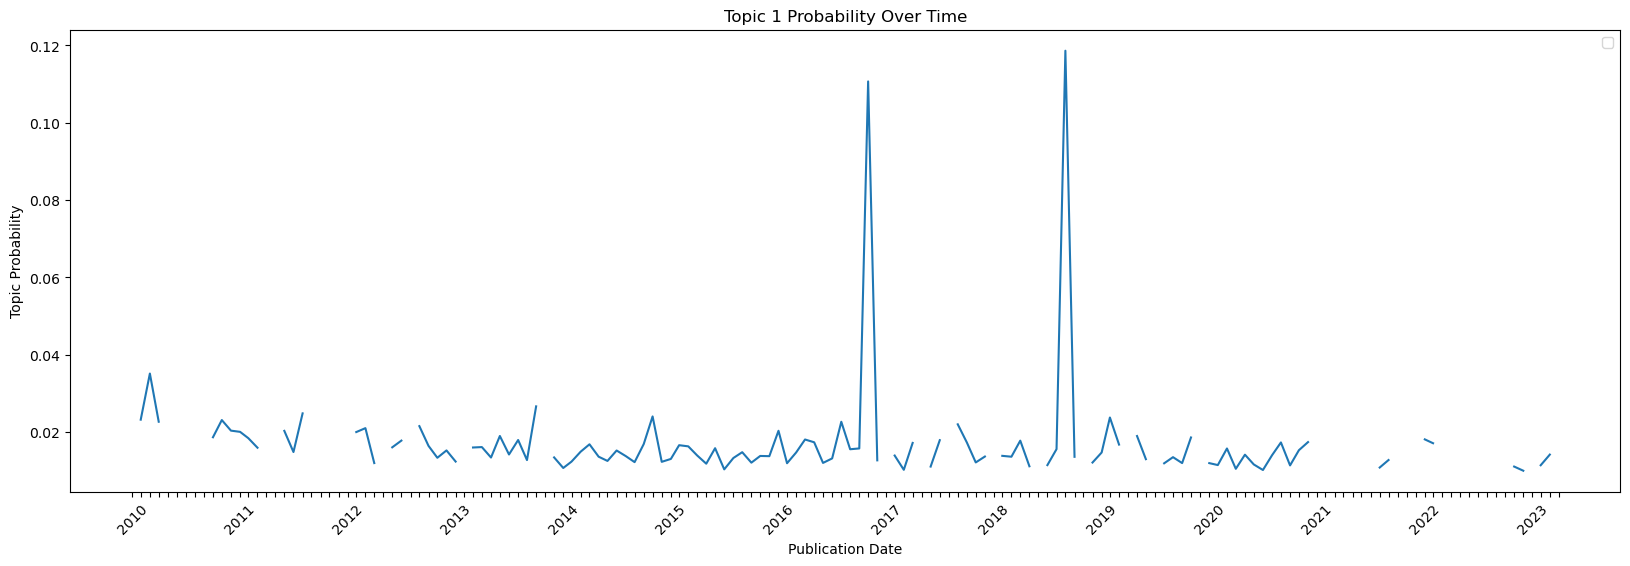

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


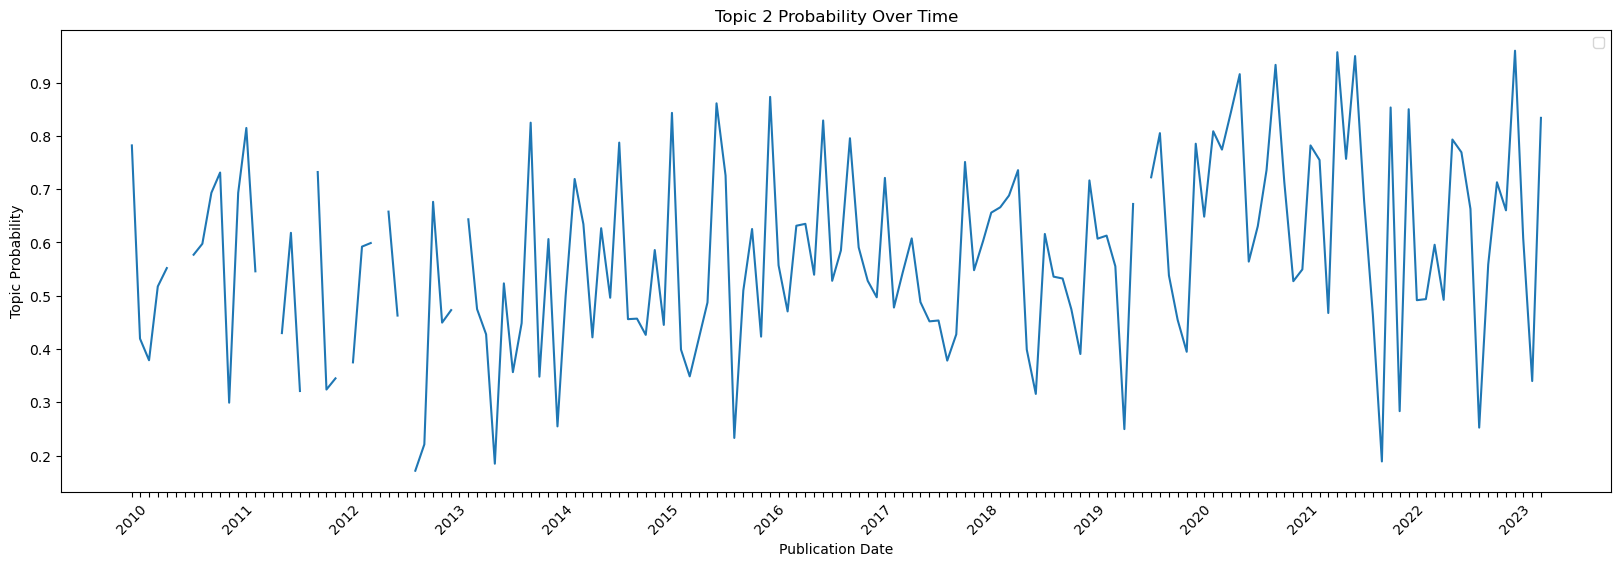

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


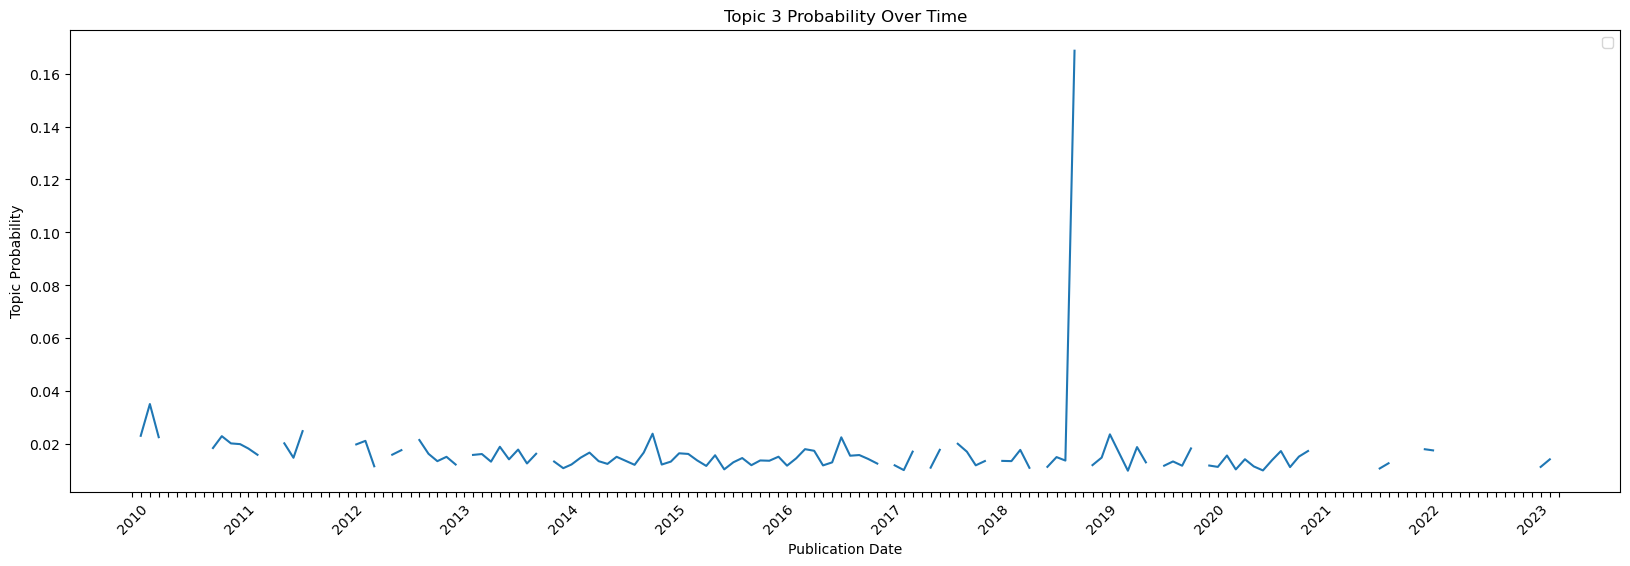

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


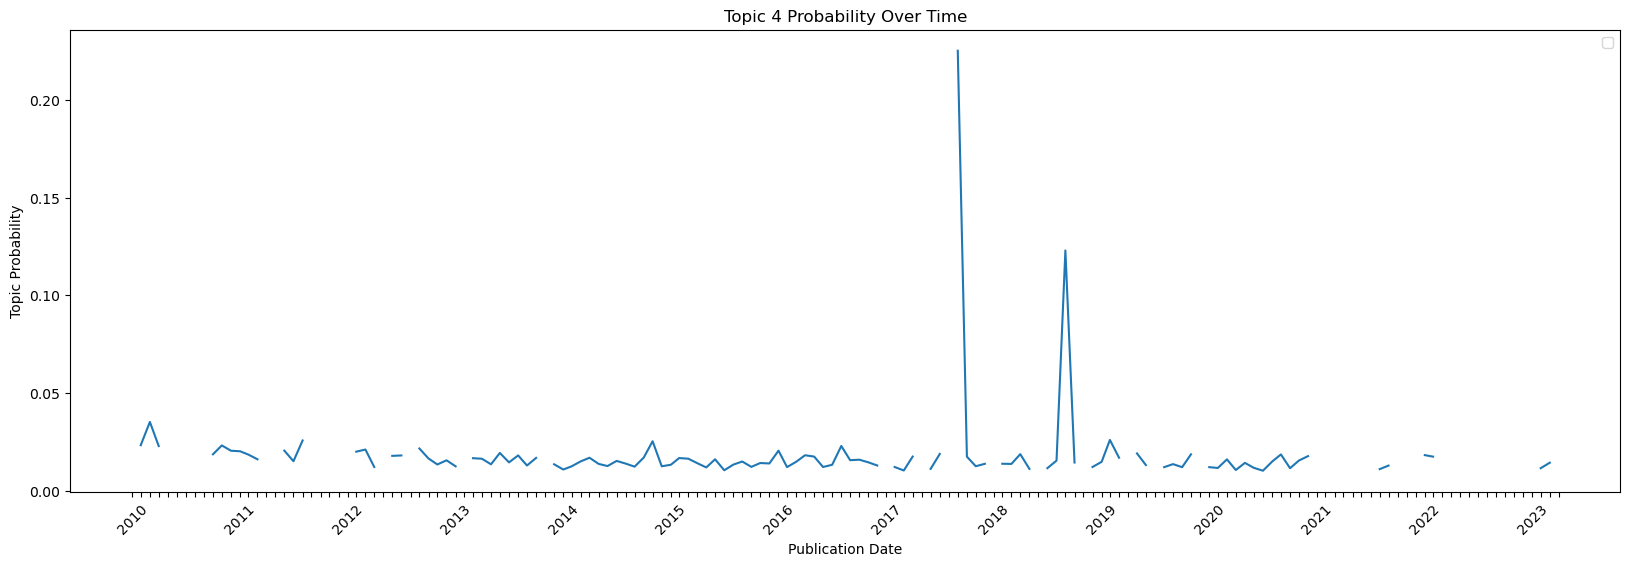

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


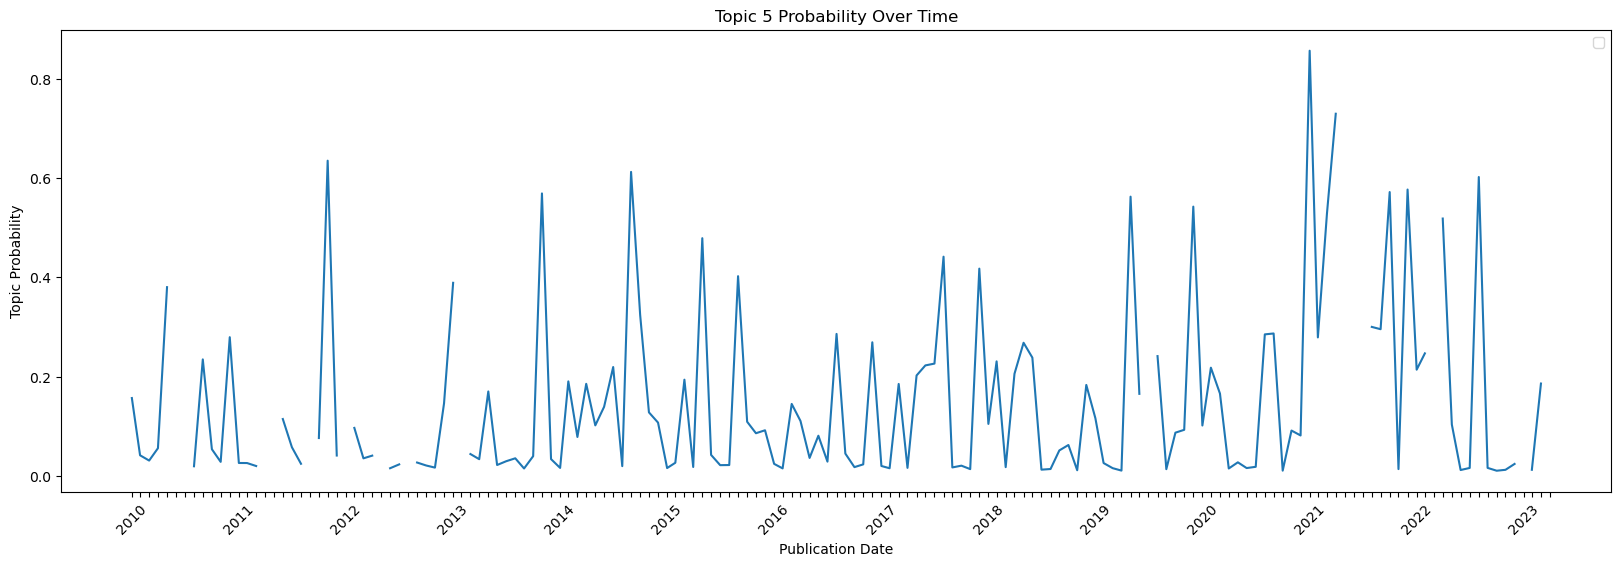

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


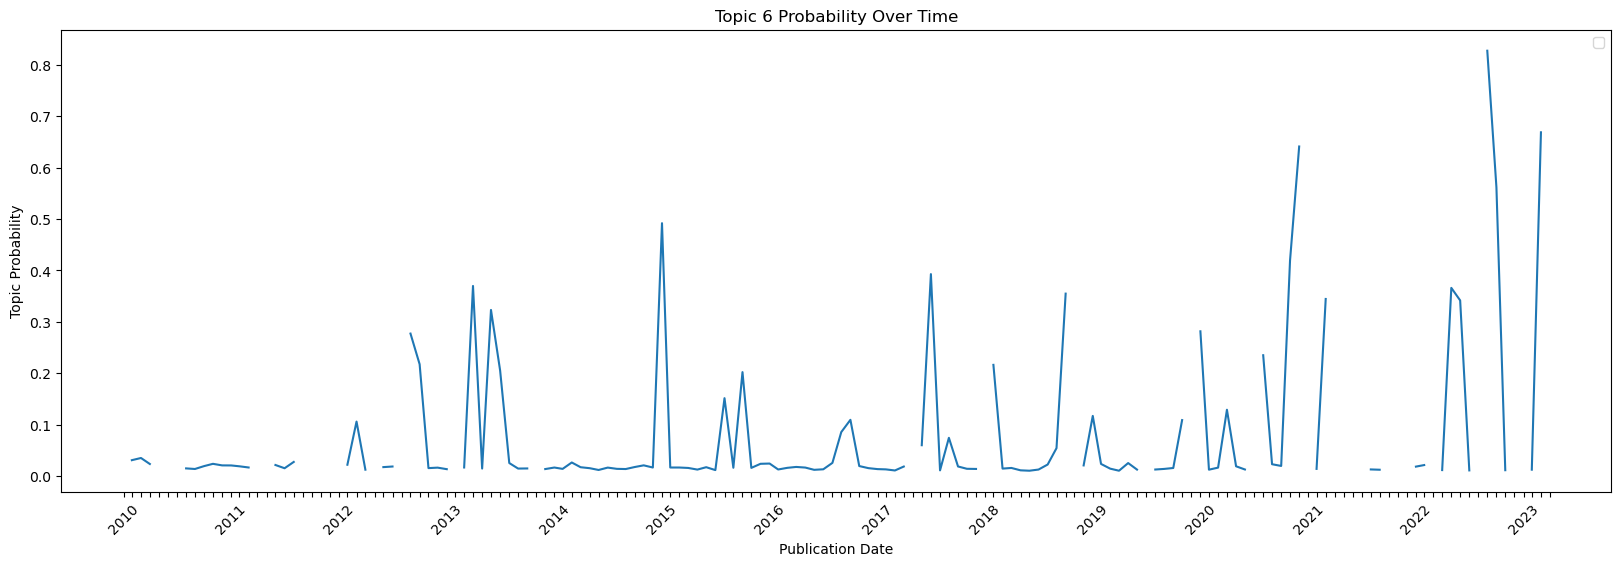

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


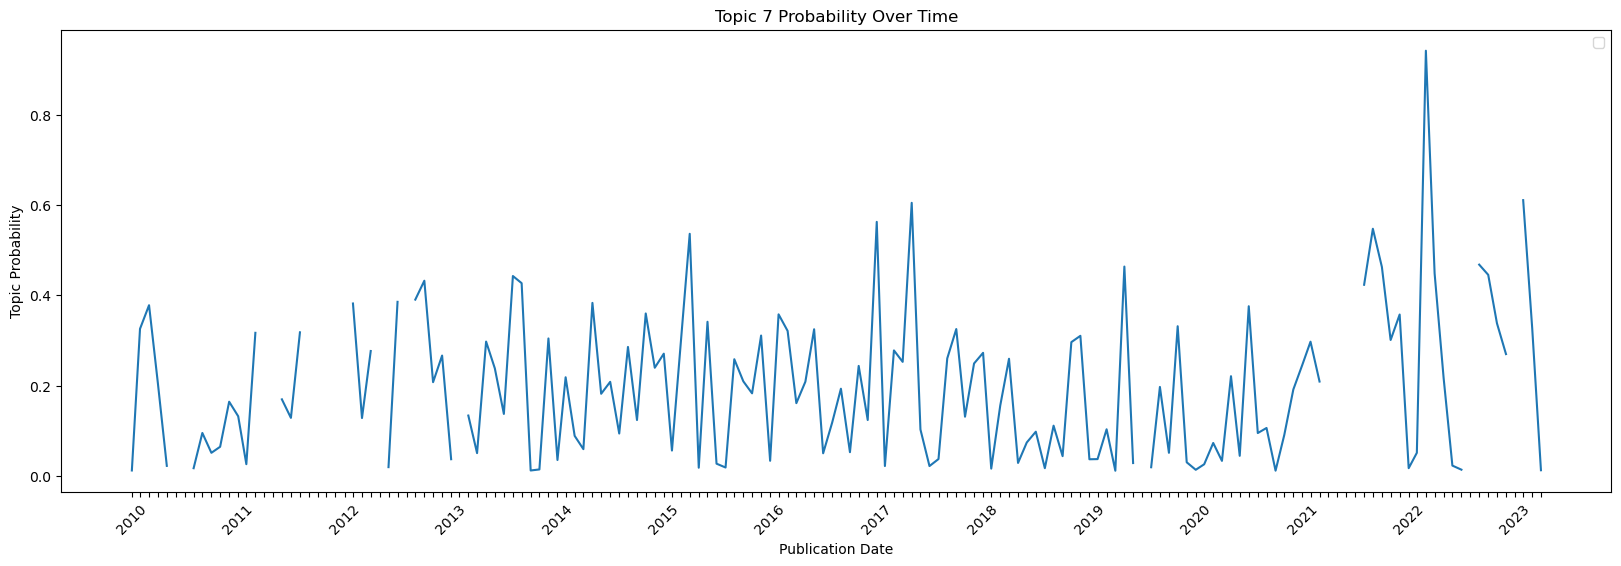

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


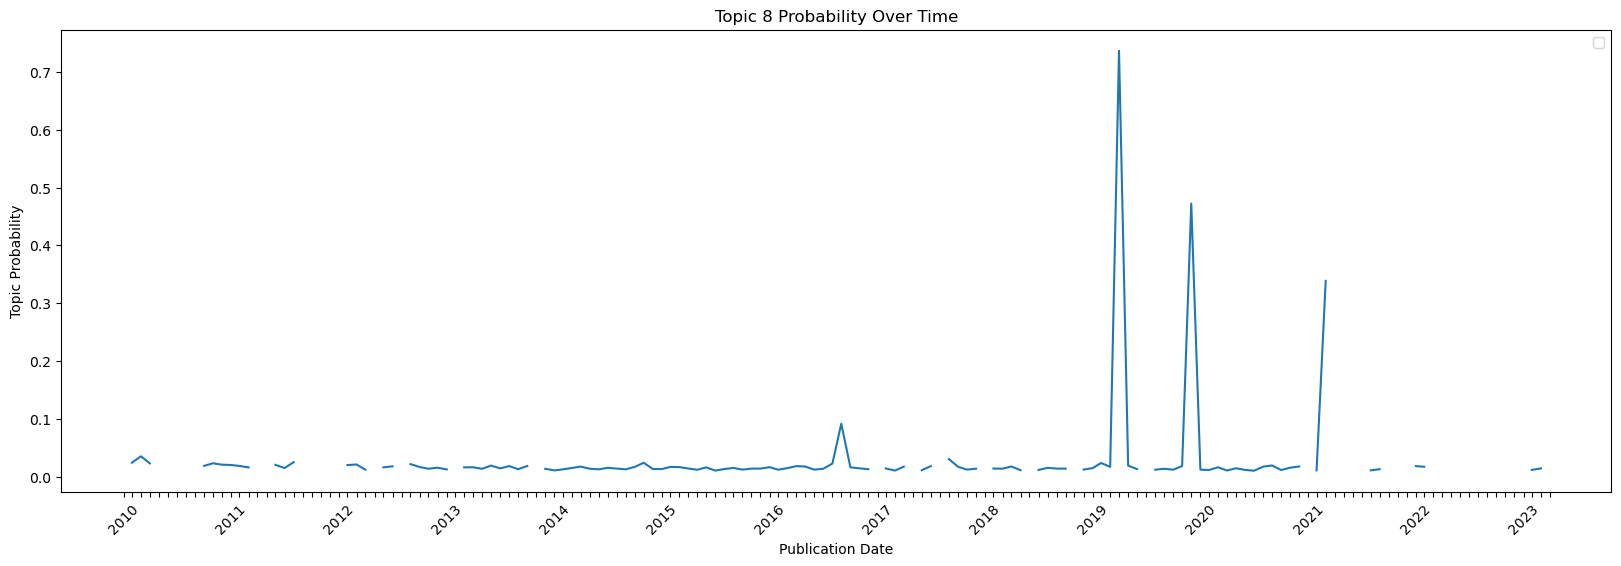

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


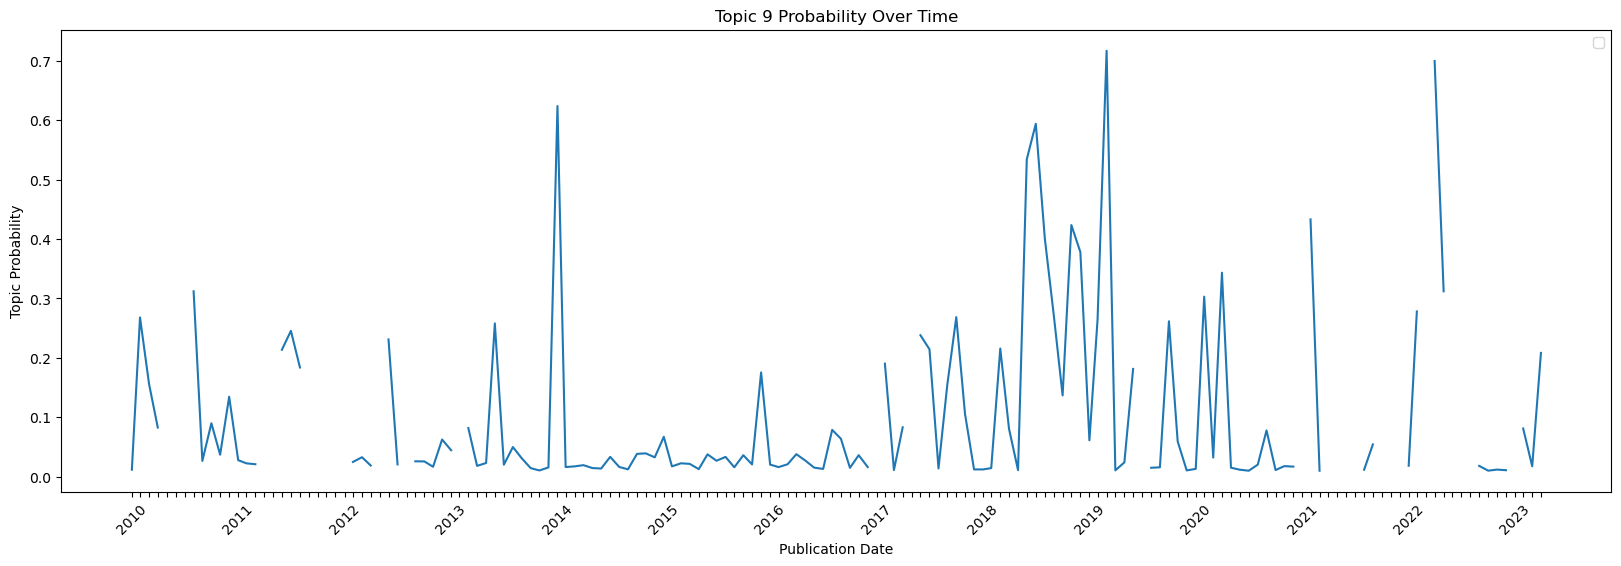

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


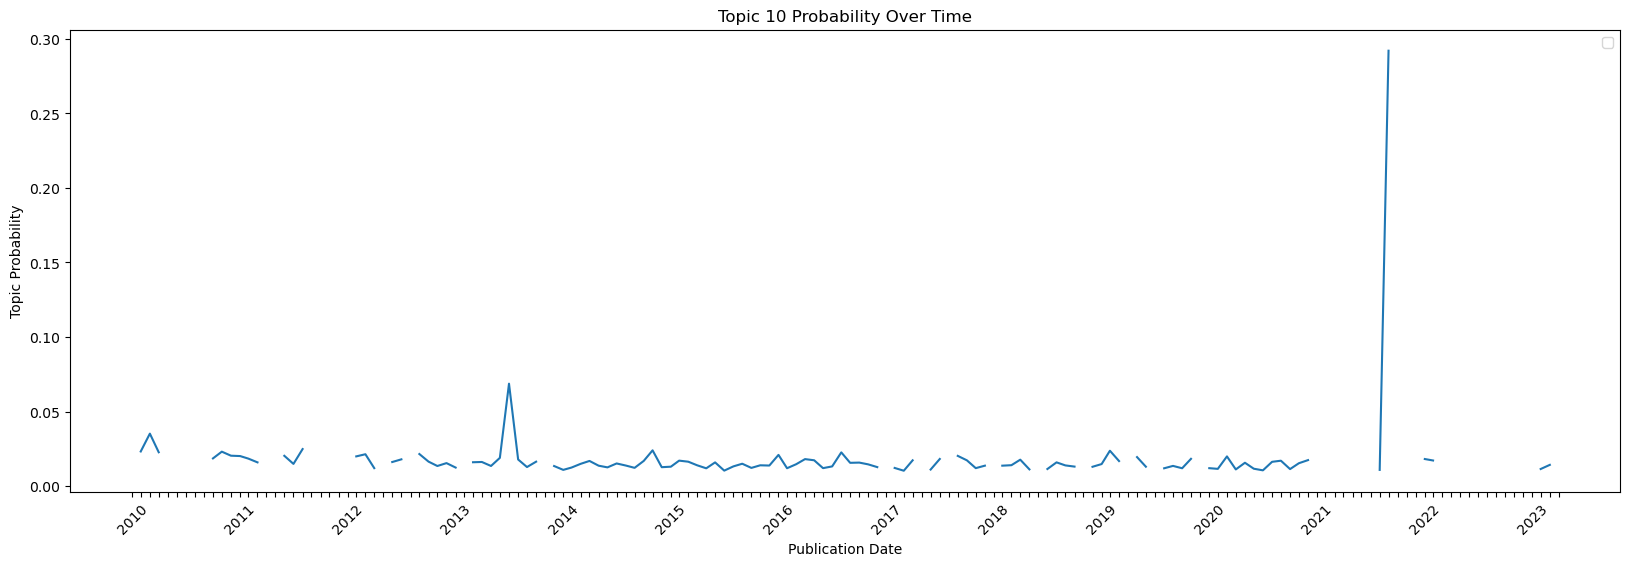

In [99]:
#Create for each topic the probability over time graph
import pandas as pd
import matplotlib.pyplot as plt

# Create a new DataFrame to store the document topic probabilities and publication dates
topic_data = pd.DataFrame(columns=['Publication Date'] + ['Topic {}'.format(i) for i in range(num_topics)])

# Iterate over each document and extract the topic probabilities and publication date
for i, doc in enumerate(all_topics):
    doc_topics = doc[0]
    publication_date = dataMBO['datetime'].iloc[i]
    
    # Create a dictionary to store the topic probabilities and publication date
    topic_prob_dict = {'Publication Date': publication_date}
    for topic, prob in doc_topics:
        topic_prob_dict['Topic {}'.format(topic)] = prob
    
    # Append the topic probabilities and publication date to the DataFrame
    topic_data = pd.concat([topic_data, pd.DataFrame([topic_prob_dict])], ignore_index=True)

# Convert the publication date column to datetime format
topic_data['Publication Date'] = pd.to_datetime(topic_data['Publication Date'])

# Set the publication date column as the DataFrame index
topic_data.set_index('Publication Date', inplace=True)

# Get the number of topics
num_topics = len(topic_data.columns)

# Create separate plots for each topic
for i in range(num_topics):
    fig, ax = plt.subplots(figsize=(20, 6))
    
    # Group the data by year and month and calculate the mean value for each group
    monthly_data = topic_data['Topic {}'.format(i)].resample('M').mean()
    
    # Plot the data
    ax.plot(monthly_data.index, monthly_data.values)
    
    # Formatting the x-axis ticks
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))  # Set the maximum number of ticks to 10
    ax.set_xticks(monthly_data.index)
    ax.set_xticklabels([x.strftime('%Y') if x.month == 1 else '' for x in monthly_data.index], rotation=45)
    
    # Formatting the plot
    ax.set_xlabel('Publication Date')
    ax.set_ylabel('Topic Probability')
    ax.set_title('Topic {} Probability Over Time'.format(i+1))
    ax.legend()

    plt.show()


    
    
#    xticks = [(str(year)) if month == 1 else ('') for year, month in topic_data.index.tolist()]
#    plt.xticks(np.arange(topic_data.shape[0]), xticks, rotation=90);
#    plt.gca().set_xlabel('')
#    plt.rc('font', **font)


## Semantic network analysis

In [5]:
def preprocess(text_col):
    # convert to lowercase
    text_col = text_col.apply(lambda x: ' '.join([w.lower() for w in x.split()]))
    
   # remove stopwords
    lst = 'de en van ik te dat die in een hij het niet zijn is was op aan met als voor had er maar om hem dan zou of wat mijn men dit zo door over ze zich bij ook tot je mij uit der daar haar naar heb hoe heeft hebben deze u want nog zal me zij nu ge geen omdat iets worden toch al waren veel meer doen toen moet ben zonder kan hun dus alles onder ja eens hier  wie werd  altijd doch  wordt wezen kunnen ons zelf tegen na reeds wil kon niets uw iemand geweest andere aan af al alle alleen alles als alsmede ander andere anders ben bij bijna bijv bijvoorbeeld binnen boven bovendien bv daar daaraan daarbij daarbuiten daardoor daarin daarna daarnaast daarom daaronder daarop daarover daartoe daaruit daarvan daarvoor dan dat de der deze die dit door doordat dus dwz echter een eens eerst en enz er ermee erg ergens ervan ervaring ervoor etc even evenals eveneens ge geen gehad geweest geworden had hadden heb hebben hebt heden heeft hem hen het hier hieraan hierbij hierdoor hierin hiermee hierna hieronder hierop hiertoe hieruit hiervan hiervoor hij hoe hoewel hun ik in indien is ja je jij jullie kan kon konden kunt kunnen maar maw me mee men met middels mijn misschien mits na naar naast nadat nee net niet niets nl nog nogal nou nu of om omdat ondermeer ons onze ook op over overig overige overigens reeds sinds slechts soms tbv te tegen ten tenzij ter terug terwijl tevens tijdens toch toe toen tot totdat tussen uit uw vaak van vanaf vandaar vanuit vanwege vervolgens volgens voor vooraf vooral voordat voorheen voornamelijk waar waaraan waarbij waardoor waarin waarmee waarna waarom waarop waaronder waaruit waarvan waarvoor wanneer want waren was wat we weer wel welk welke wellicht werd werden wie wij worden wordt zal ze zeer zelf zelfs zich zij zijn zo zoals zodat zonder zowel zou zouden zult zullen'

    def convert(lst):
        return ([i for i in lst.split()])

    list = convert(lst)
    
    additional_stopwords = ['mensen', 'jongeren', 'minister', 'komen', 'komt', 'twee', 'drie', 'vier', 'vijf', 'zes', 'zeven', 'acht', 'negen', 'tien', 'krijgen', 'maken', 'wel', 'gaat', 'gaan', 'zegt', 'volgens', 'studenten', 'leerlingen', 'volgens', 'jaar', 'scholen', 'school', 'moeten', 'mbo', 'onderwijs']
    stopwords = set(nltk.corpus.stopwords.words('dutch') + additional_stopwords + list)
    
    text_col = text_col.apply(lambda x: ' '.join([w for w in x.split() if w not in stopwords]))

    # remove short words
    text_col = text_col.apply(lambda x: ' '.join([w.strip() for w in x.split() if len(w.strip()) >= 4]))

    # tokenize
    text_col = text_col.apply(lambda x: [nltk.word_tokenize(t) for t in nltk.sent_tokenize(x)])

    # remove punctuation
    text_col = text_col.apply(lambda x: [[w for w in sent if w.strip(string.punctuation)] for sent in x])

    # remove numbers
    text_col = text_col.apply(lambda x: [[w for w in sent if not w.isdigit()] for sent in x])

    # Remove 's
    text_col = text_col.apply(lambda x: [[w for w in sent if w != "'s"] for sent in x])

    return text_col

dataMBO['processed_text_network'] = preprocess(dataMBO['content'])

C:\Users\User\AppData\Local\Temp\ipykernel_8328\1799178220.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataMBO['processed_text_network'] = preprocess(dataMBO['content'])


In [6]:
totallen = 0
for i in dataMBO.index:
    row_len = len(dataMBO['processed_text_network'][i])
    totallen += row_len

totallen


18807

## Network 2

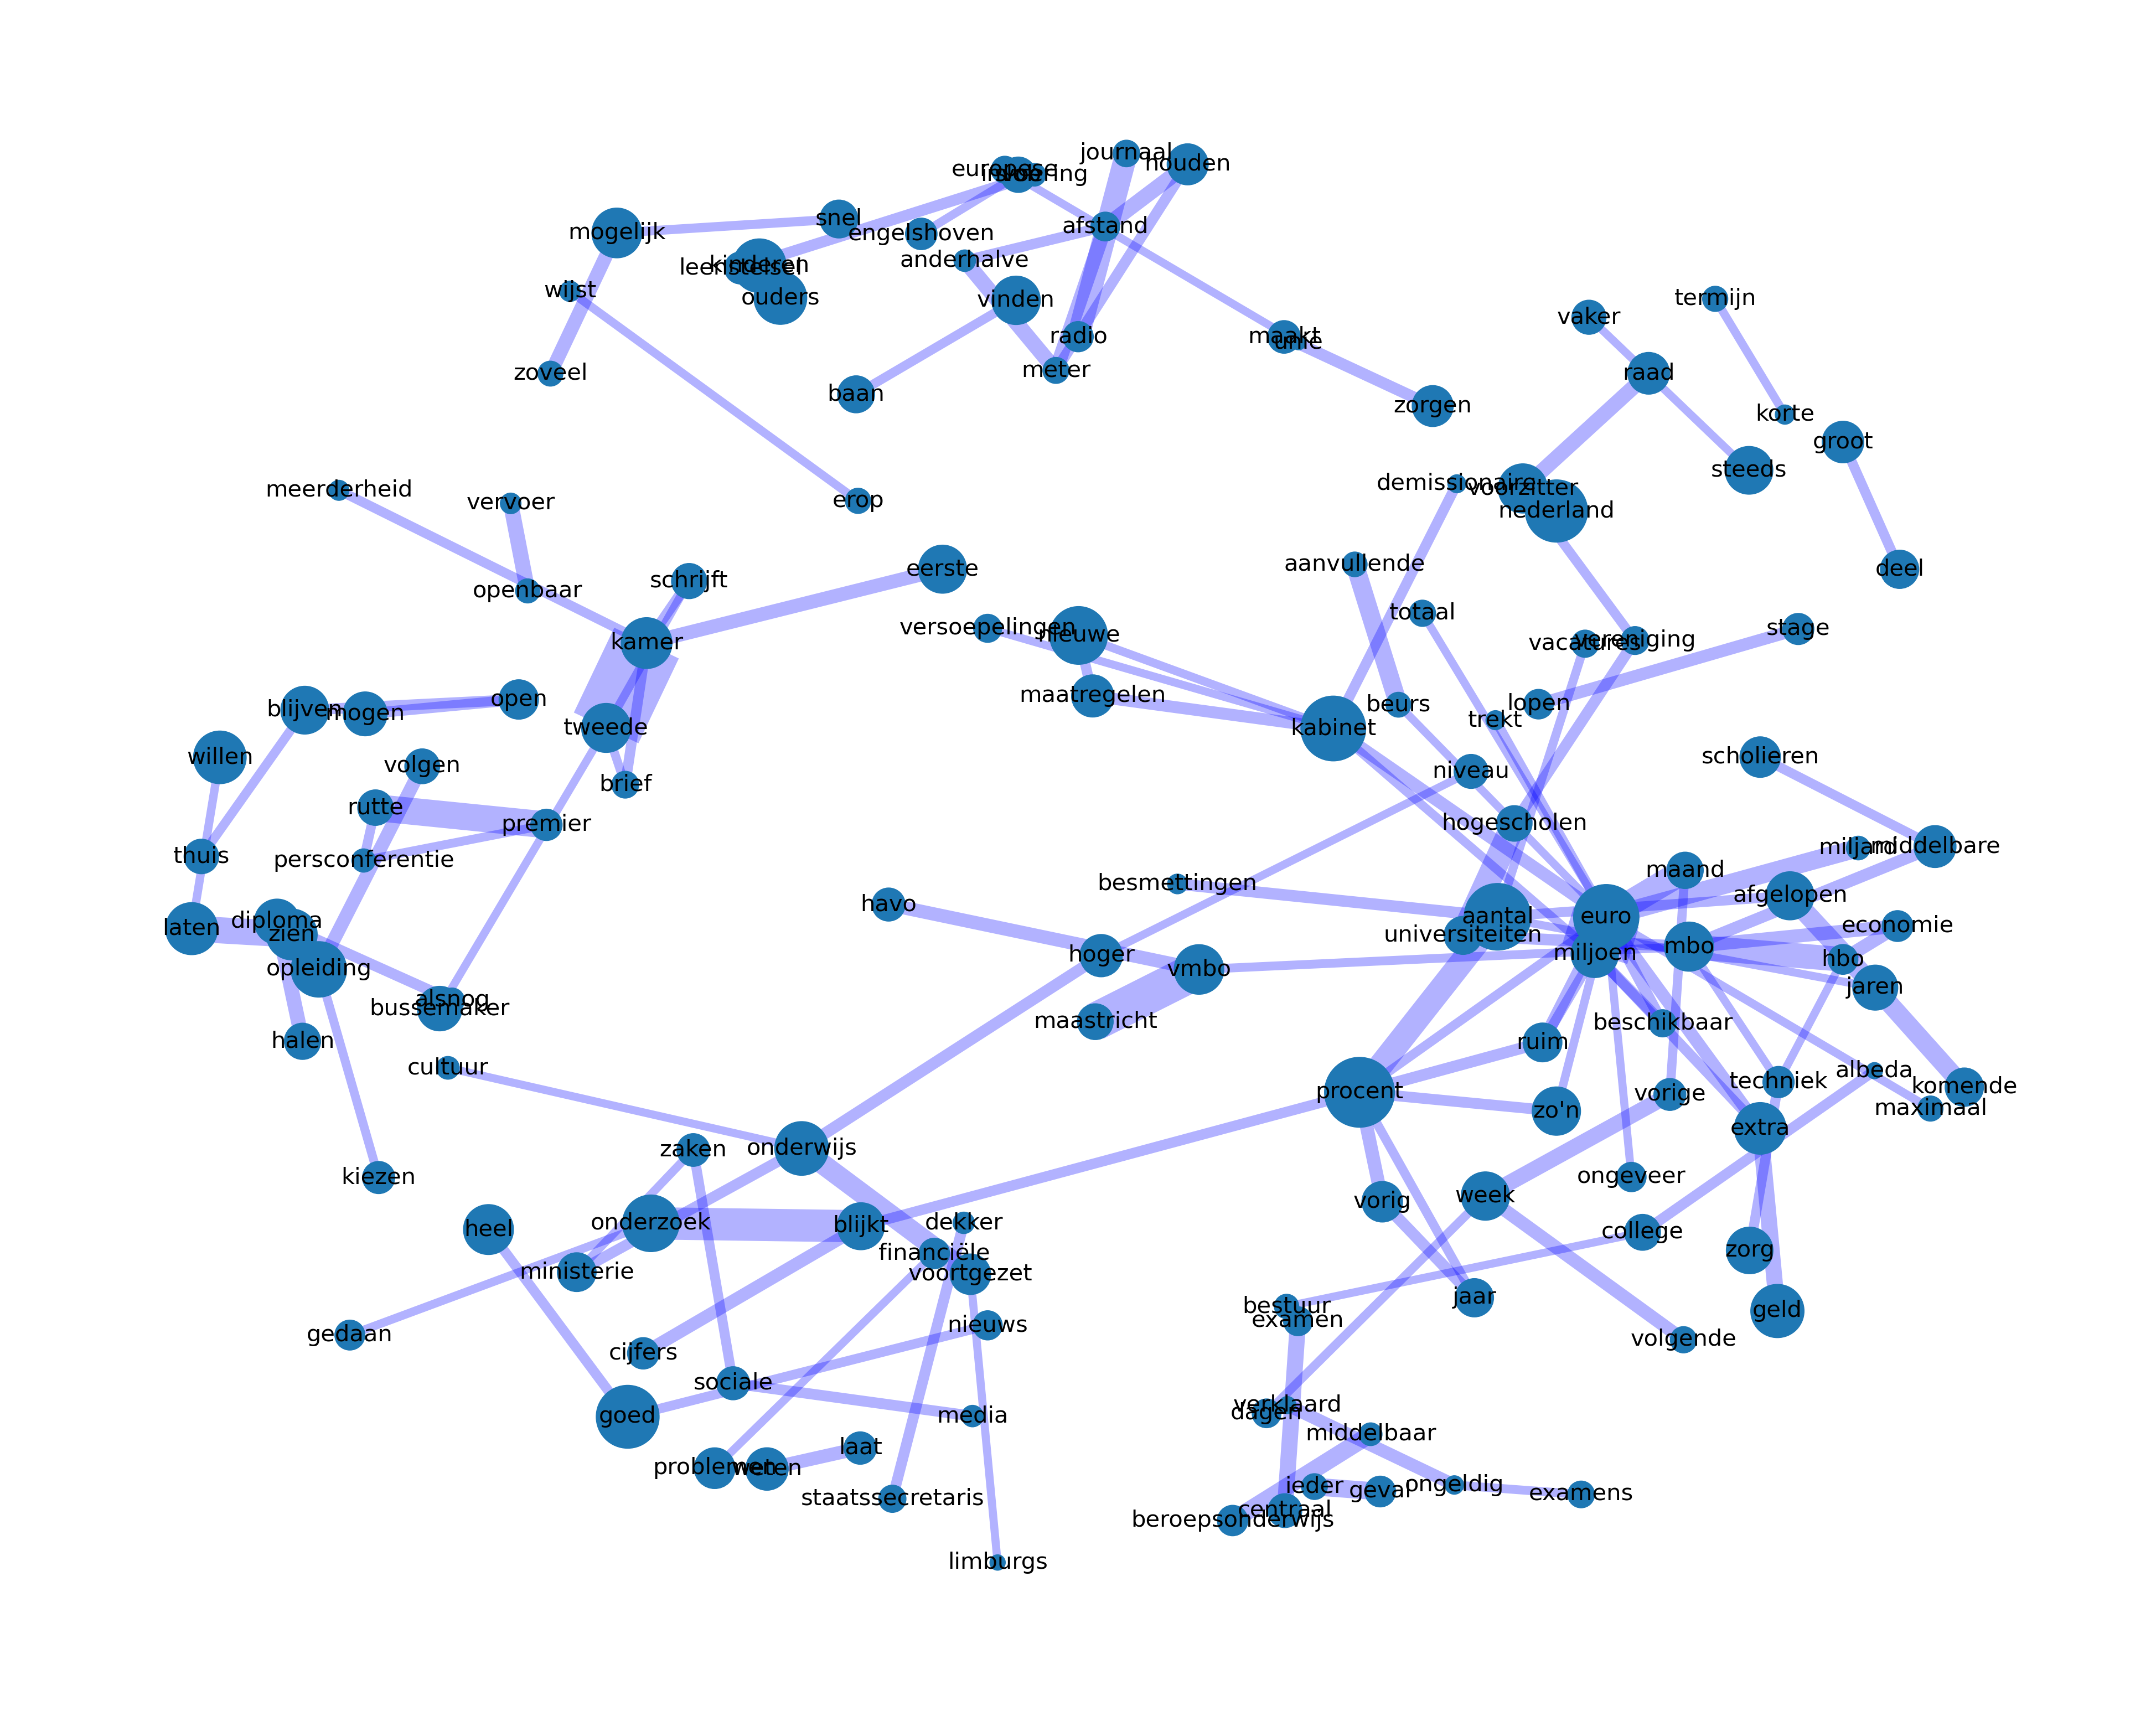

In [194]:
import nltk
from nltk.corpus import stopwords
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt

# Create a co-occurrence matrix
co_occurrence_matrix = Counter()
for sentence in dataMBO['processed_text_network']:
    for word_list in sentence:
        for i, word in enumerate(word_list):
            for j in range(i + 1, len(word_list)):
                co_occurrence_matrix[(word, word_list[j])] += 1
                co_occurrence_matrix[(word_list[j], word)] += 1

# Build the network
G = nx.Graph()
for pair, weight in co_occurrence_matrix.items():
    if weight > 20 and pair[0] != pair[1]:
        G.add_edge(pair[0], pair[1], weight=weight)

# Calculate total co-occurrence for each word
node_sizes = {word: sum(weight for pair, weight in co_occurrence_matrix.items() if word in pair) for word in G.nodes}

# Visualize the network
plt.figure(figsize=(50, 40))
pos = nx.spring_layout(G, k=1)
nx.draw_networkx_nodes(G, pos, node_size=[node_sizes[word] for word in G.nodes], cmap=plt.cm.Blues)
nx.draw_networkx_edges(G, pos, width=[0.5*co_occurrence_matrix[pair] for pair in G.edges], alpha=0.3, edge_color='blue')
nx.draw_networkx_labels(G, pos, font_size=30, font_family='sans-serif')
plt.axis('off')
plt.savefig('network_plot.png')

plt.show()


## Network 1

In [165]:
#nt = Network('800px', '100%', notebook=True)
#nt.from_nx(G)
#nt.show_buttons(filter_=['physics'])
#nt.show('nx.html')

G = nx.Graph()
for pair, weight in co_occurrence_matrix.items():
    if weight > 10 and pair[0] != pair[1]:
        G.add_edge(pair[0], pair[1], weight=weight)

node_sizes2 = {word: sum(weight for pair, weight in co_occurrence_matrix.items() if word in pair) for word in G.nodes}

# Create the network visualization object
nt = Network(height='800px', width='100%', notebook=True)

# Add nodes and their sizes to the network
for node, size in node_sizes2.items():
    nt.add_node(node, value=size)

# Add edges and their widths to the network
for edge in G.edges:
    source, target = edge
    weight = G[source][target]['weight']
    nt.add_edge(source, target, value=weight)

# Display the network visualization
nt.show_buttons(filter_=['physics'])
nt.show('network1.html')

network1.html


In [195]:
print(nx.info(G))

Graph with 140 nodes and 123 edges


C:\Users\User\AppData\Local\Temp\ipykernel_16588\2606185536.py:1: DeprecationWarning:

info is deprecated and will be removed in version 3.0.




## Centralities

In [196]:
degree_centrality = nx.degree_centrality(G)

# declaring an empty list
listr = []
 
# appending all the values in the list
for value in degree_centrality.values():
    listr.append(value)
 
# Standard deviation of list
# Using sum() + list comprehension
mean = sum(listr) / len(listr)
variance = sum([((x - mean) ** 2) for x in listr]) / len(listr)
res = variance ** 0.5
minimum = min(listr)
maximum = max(listr)
print(
    'mean ', mean, 
    'standard deviation', res, 
    'minimum', minimum, 
    'maximum', maximum)


betweenness_centrality = nx.betweenness_centrality(G, k=10)

# declaring an empty list
listr2 = []
 
# appending all the values in the list
for value in betweenness_centrality.values():
    listr2.append(value)
 
# Standard deviation of list
# Using sum() + list comprehension
mean2 = sum(listr2) / len(listr2)
variance2 = sum([((x - mean2) ** 2) for x in listr2]) / len(listr2)
res2 = variance2 ** 0.5
minimum2 = min(listr2)
maximum2 = max(listr2)
print(
    'mean ', mean2, 
    'standard deviation', res2, 
    'minimum', minimum2, 
    'maximum', maximum2)


mean  0.01264131551901333 standard deviation 0.010906254779642188 minimum 0.007194244604316547 maximum 0.10071942446043167
mean  0.0015118340110520279 standard deviation 0.005511042567127352 minimum 0.0 maximum 0.03977687415285163


In [184]:
#Betweenness centrality - important nodes connect other nodes
plot_betweenness_centrality(G,max_nodes =20)

C:\Users\User\anaconda3\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\User\anaconda3\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [181]:
# Degree centrality - important nodes have many connections
plot_degree_centrality(G,max_nodes =20)

C:\Users\User\anaconda3\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\User\anaconda3\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [189]:
scatter_centralities(G)

C:\Users\User\anaconda3\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\User\anaconda3\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



## Betweenness network

In [188]:
def plot_betweenness_centrality(text_network,max_nodes):
    bc = (nx.betweenness_centrality(text_network,weight='weight'))
    sorted_bc = dict(sorted(bc.items(),reverse=True, key=lambda item: item[1]))
    nodes = list(sorted_bc.keys())[:max_nodes]
    values = list(sorted_bc.values())[:max_nodes]
    fig = px.bar( x=nodes, y=values, title='Top 20 betweenness centrality scores', labels={
        "x":  "nodes",
        "y": "betweenness centrality score"})
    fig.show()
def plot_degree_centrality(text_network,max_nodes , normalized =True):
    if normalized : 
        bc = (nx.degree_centrality(text_network))
    else : 
        bc = dict(text_network.degree())
    #print(bc)
    sorted_bc = dict(sorted(bc.items(),reverse=True, key=lambda item: item[1]))
    nodes = list(sorted_bc.keys())[:max_nodes]
    values = list(sorted_bc.values())[:max_nodes]
    fig = px.bar( x=nodes, y=values, title='Top 20 degree centrality scores', labels={
        "x":  "nodes",
        "y": "degree centrality score"
    })
    fig.show()
def scatter_centralities(text_network) :
    deg = (nx.degree_centrality(text_network))
    bc = (nx.betweenness_centrality(text_network,weight='weight'))
    values_bc =  list(bc.values())
    values_deg =  list(deg.values())
   # print(labels)
    fig = px.scatter(x=values_deg, y=values_bc, , title='relation of degree centrality and betweenness centrality', labels={
        "x":  "degree centrality score",
        "y": "betweenness centrality score"})
    fig.show()
    

def create_graph(text):

    word_list = []
    G2 = nx.Graph()
    pbar = tqdm(total=len(text))
    for cell in text:
        for sentence in cell:
            for i, word in enumerate(sentence):
                if i != len(sentence)-1:
                    word_a = word
                    word_b = sentence[i+1]
                    if word_a not in word_list:
                        word_list.append(word_a)
                    if word_b not in word_list:
                        word_list.append(word_b)
                    if G2.has_edge(word_a,word_b):
                        G2[word_a][word_b]['weight'] += 1
                    else:
                        G2.add_edge(word_a,word_b, weight = 1)
            pbar.update(1)
    pbar.close()
    return G2

def calculate_central_nodes(text_network , max_nodes = -1):

    bc = (nx.betweenness_centrality(text_network,weight='weight'))
    #print(bc)
    
    nx.set_node_attributes(text_network, bc, 'betweenness')
    bc_threshold = sorted(bc.values(), reverse=True)[max_nodes]
    to_keep = [n for n in bc if bc[n] > bc_threshold]
    filtered_network = text_network.subgraph(to_keep)
    return filtered_network

def draw_final_graph(text_network, with_size=True ):

    pos = nx.spring_layout(text_network,scale=2)
    betweenness = nx.get_node_attributes(text_network,'betweenness')
    betweenness = [x*1000 for x in betweenness.values()]
    if with_size : 
         nx.draw(text_network,with_labels=True,node_size=betweenness,font_size=8,edge_cmap=plt.cm.Blues, width=1)
    else :  nx.draw(text_network,with_labels=True,font_size=10,edge_cmap=plt.cm.Blues)
    plt.draw()
    plt.show()

SyntaxError: invalid syntax (3062945142.py, line 30)

In [170]:
#nt = Network('800px', '100%', notebook=True)
#nt.from_nx(G)
#nt.show_buttons(filter_=['physics'])
#nt.show('nx.html')

G2 = nx.Graph()
for pair, weight in co_occurrence_matrix.items():
    if weight > 10 and pair[0] != pair[1]:
        G2.add_edge(pair[0], pair[1], weight=weight)

node_sizes2 = {word: sum(weight for pair, weight in co_occurrence_matrix.items() if word in pair) for word in G2.nodes}

def calculate_central_nodes(text_network , max_nodes = -1):

    bc = (nx.betweenness_centrality(text_network,weight='weight'))
    #print(bc)
    
    nx.set_node_attributes(text_network, bc, 'betweenness')
    bc_threshold = sorted(bc.values(), reverse=True)[max_nodes]
    to_keep = [n for n in bc if bc[n] > bc_threshold]
    filtered_network = text_network.subgraph(to_keep)
    return filtered_network

G2 = calculate_central_nodes(G2, max_nodes = 100)

# Create the network visualization object
nt = Network(height='800px', width='100%', notebook=True)

# Add nodes and their sizes to the network
for node, size in node_sizes2.items():
    nt.add_node(node, value=size)

# Add edges and their widths to the network
for edge in G2.edges:
    source, target = edge
    weight = G2[source][target]['weight']
    nt.add_edge(source, target, value=weight)

# Display the network visualization
nt.show_buttons(filter_=['physics'])
nt.show('network2.html')

network2.html


In [171]:
print(nx.info(G2))

degree_centrality = nx.degree_centrality(G2)

# declaring an empty list
listr = []
 
# appending all the values in the list
for value in degree_centrality.values():
    listr.append(value)
 
# Standard deviation of list
# Using sum() + list comprehension
mean = sum(listr) / len(listr)
variance = sum([((x - mean) ** 2) for x in listr]) / len(listr)
res = variance ** 0.5
minimum = min(listr)
maximum = max(listr)
print(
    'mean ', mean, 
    'standard deviation', res, 
    'minimum', minimum, 
    'maximum', maximum)


betweenness_centrality = nx.betweenness_centrality(G2, k=10)

# declaring an empty list
listr2 = []
 
# appending all the values in the list
for value in betweenness_centrality.values():
    listr2.append(value)
 
# Standard deviation of list
# Using sum() + list comprehension
mean2 = sum(listr2) / len(listr2)
variance2 = sum([((x - mean2) ** 2) for x in listr2]) / len(listr2)
res2 = variance2 ** 0.5
minimum2 = min(listr2)
maximum2 = max(listr2)
print(
    'mean ', mean2, 
    'standard deviation', res2, 
    'minimum', minimum2, 
    'maximum', maximum2)


Graph with 89 nodes and 230 edges
mean  0.05873340143003069 standard deviation 0.04650334814564734 minimum 0.011363636363636364 maximum 0.2727272727272727
mean  0.021029258098223615 standard deviation 0.04454049459794811 minimum 0.0 maximum 0.3271635321096529


C:\Users\User\AppData\Local\Temp\ipykernel_16588\3629387293.py:1: DeprecationWarning:

info is deprecated and will be removed in version 3.0.


